In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "./cache"

import cv2
import torch
from transformers import SwinModel, SwinConfig
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from transformers.models.swin.modeling_swin import (
    SwinLayer,
    SwinSelfAttention,
    SwinSelfOutput,
    SwinIntermediate,
    SwinOutput
)
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt



2025-05-22 23:19:58.757706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 23:19:58.759647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 23:19:58.797558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 23:19:59.404387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import inspect

print(inspect.signature(SwinSelfAttention.__init__))
print(inspect.signature(SwinConfig.__init__))

(self, config, dim, num_heads, window_size)
(self, image_size=224, patch_size=4, num_channels=3, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7, mlp_ratio=4.0, qkv_bias=True, hidden_dropout_prob=0.0, attention_probs_dropout_prob=0.0, drop_path_rate=0.1, hidden_act='gelu', use_absolute_embeddings=False, initializer_range=0.02, layer_norm_eps=1e-05, encoder_stride=32, out_features=None, out_indices=None, **kwargs)


In [3]:
import pathlib

In [4]:
TRAIN_PATH = "ISIC2018_Task1-2_Training_Input"
MASK_PATH = "ISIC2018_Task1_Training_GroundTruth"

In [5]:
print(torch.cuda.is_available())  # 预期输出 True
print(torch.cuda.get_device_capability(0))  # SM 版本需 ≥ 7.0

True
(8, 0)


## Model Constructing

### Test now(2025.5.19) still in test but can run now

In [6]:
def window_partition(x, window_size, H, W):
    B, L, C = x.shape
    x = x.view(B, H, W, C)
    x = x.unfold(1, window_size, window_size).unfold(2, window_size, window_size)
    x = x.contiguous().view(-1, window_size*window_size, C)
    return x

In [7]:
def window_reverse(windows, window_size, H, W, B):
    num_windows = (H // window_size) * (W // window_size)
    x = windows.view(B, num_windows, window_size * window_size, -1)
    x = x.view(B, H//window_size, W//window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x.view(B, H*W, -1)

In [8]:
class SimpleSwinBlock(torch.nn.Module):
    def __init__(self, config, dim, num_heads):
        super().__init__()
        self.config = config
        self.dim = dim
        self.num_heads = num_heads
        self.self_output = SwinSelfOutput(config, dim)
        self.intermediate = SwinIntermediate(config, dim)
        self.output = SwinOutput(config, dim)
        self.norm1 = torch.nn.LayerNorm(dim, eps=config.layer_norm_eps)
        self.norm2 = torch.nn.LayerNorm(dim, eps=config.layer_norm_eps)
        # 将注意力层作为模块的一个属性
        self.attn_dict = torch.nn.ModuleDict()

    def get_attn(self, window_size):
        # 动态创建或更新注意力层
        key = str(window_size)
        if key not in self.attn_dict:
            device = next(self.parameters()).device
            self.attn_dict[key] = SwinSelfAttention(self.config,self.dim,self.num_heads,window_size).to(device)
        return self.attn_dict[key]

    def forward(self, x, H, W):
        max_window = 7
        window_size = min(max_window, H, W)
        for ws in range(window_size, 0, -1):
            if H % ws == 0 and W % ws == 0:
                window_size = ws
                break
        
        # 获取适合当前分辨率的注意力层
        attn = self.get_attn(window_size)
        
        shortcut = x
        B = shortcut.shape[0]
        # (batch_size, seq_len, dim)
        x = self.norm1(x)
        # (batch_size, seq_len, dim)
        x_windows = window_partition(x, window_size, H, W)
        x_windows = attn(x_windows)
        if isinstance(x_windows, tuple):
            x_windows = x_windows[0]
        x = window_reverse(x_windows, window_size, H, W, B)
        # (batch_size, seq_len, dim)
        x = self.self_output(x, shortcut)
        # (batch_size, seq_len, dim)
        shortcut2 = x
        x = self.norm2(x)
        x = self.intermediate(x)
        #(batch_size, seq_len, 4*dim)
        x = self.output(x)
        x = x + shortcut2
        #(batch_size, seq_len, dim)
        return x

In [9]:
class PatchExpand(torch.nn.Module):
    def __init__(self, input_dim, output_dim, scale=2):
        super().__init__()
        self.proj = torch.nn.Linear(input_dim, output_dim * scale * scale)
        self.scale = scale
        self.output_dim = output_dim

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(L ** 0.5)
        x = self.proj(x)  # (B, L, output_dim*scale*scale)
        x = x.view(B, H, W, self.scale, self.scale, self.output_dim)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        # (B, H, scale, W, scale, output_dim)
        x = x.view(B, H * self.scale, W * self.scale, self.output_dim)
        return x.view(B, -1, self.output_dim)
        # (B, L*scale*scale, output_dim)

In [10]:
class SwinTransformerDecoder(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # 对应编码器输出的通道和分辨率
        self.dims = [768, 384, 192, 96]
        self.heads = [32, 16, 8, 4]
        self.config = config

        self.up_blocks = torch.nn.ModuleList()
        for i in range(3):
            self.up_blocks.append(PatchExpand(self.dims[i], self.dims[i+1], scale=2))
            # 使用1x1卷积替代线性层进行特征融合
            self.up_blocks.append(torch.nn.Sequential(
                torch.nn.Conv2d(self.dims[i+1]*2, self.dims[i+1], 1),
                torch.nn.BatchNorm2d(self.dims[i+1]),
                torch.nn.ReLU()
            ))
            self.up_blocks.append(SimpleSwinBlock(config, self.dims[i+1], self.heads[i+1]))
            self.up_blocks.append(SimpleSwinBlock(config, self.dims[i+1], self.heads[i+1]))

        # 使用多层卷积进行最终映射
        self.final_proj = torch.nn.Sequential(
            torch.nn.Conv2d(self.dims[-1], 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32), 
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 1, 1)
        )

    def forward(self, features):
        x = features[0]  # 7x7x768
        skips = features[1:]  # [14x14x384, 28x28x192, 56x56x96]
        for i in range(3):
            x = self.up_blocks[i*4](x)  # PatchExpand
            skip = skips[i]
            # 上采样skip到x的空间分辨率
            if x.shape[1] != skip.shape[1]:
                B, L_skip, C_skip = skip.shape
                H_skip = W_skip = int(L_skip ** 0.5)
                H_x = W_x = int(x.shape[1] ** 0.5)
                skip_ = skip.view(B, H_skip, W_skip, C_skip).permute(0, 3, 1, 2)
                skip_ = torch.nn.functional.interpolate(skip_, size=(H_x, W_x), mode='nearest')
                skip = skip_.permute(0, 2, 3, 1).reshape(B, H_x * W_x, C_skip)
            x = torch.cat([x, skip], dim=-1)
            
            # 将特征重塑为4D张量用于1x1卷积
            B, L, C = x.shape
            H = W = int(L ** 0.5)
            x = x.view(B, H, W, C).permute(0, 3, 1, 2)
            x = self.up_blocks[i*4+1](x)
            x = x.permute(0, 2, 3, 1).reshape(B, -1, self.dims[i+1])
            
            x = self.up_blocks[i*4+2](x, H, W)
            x = self.up_blocks[i*4+3](x, H, W)
        # 最终投影
        B, L, C = x.shape
        H = W = int(L ** 0.5)
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode="nearest")
        x = self.final_proj(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class SwinUNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", output_hidden_states=True)
        self.decoder = SwinTransformerDecoder(self.encoder.config)
        # for name, param in self.encoder.named_parameters():
        #     if "layers.2" not in name and "layers.3" not in name:
        #         param.requires_grad = False

    def forward(self, x):
        outputs = self.encoder(x)
        hs = outputs.hidden_states
        # [7x7x768, 14x14x384, 28x28x192, 56x56x96]
        features = []
        for i in [3, 2, 1, 0]:
            feat = hs[i]
            B, L, C = feat.shape
            H = W = int(L ** 0.5)
            features.append(feat.view(B, H, W, C).reshape(B, -1, C))
        return self.decoder(features)

In [12]:
# model = SwinUNet()
# dummy_input = torch.randn(32, 3, 224, 224)
# output = model(dummy_input)
# print('输出shape:', output.shape)  # 应为 [2, 1, 224, 224]

In [13]:
# loss = torch.nn.BCELoss()(output, torch.rand(32, 1, 224, 224))
# loss.backward()
# grad_exists = [p.grad is not None for p in model.parameters()]
# print("Gradients exist:", sum(grad_exists), "/", len(grad_exists))

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
SIZE = 224
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20

## Data Preparation

In [15]:
class ISICDataset(Dataset):
    def __init__ (self, image_dir, mask_dir, size, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.ids = [image_dir[:-4] for image_dir in os.listdir(image_dir) if image_dir.endswith('.jpg')]
        self.size = size
    
    def __len__ (self):
        return len(self.ids)
    
    def __getitem__ (self, idx):
        image_path = os.path.join(self.image_dir, self.ids[idx] + ".jpg")
        mask_path = os.path.join(self.mask_dir, self.ids[idx] + "_segmentation.png")

        img = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img, mask = self.transform(img, mask)
        
        mask = (mask > 0.5).float()

        img = transforms.functional.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        return img, mask

#### Loading and Preparing

In [16]:
class JointTransform:
    def __init__(self, size, rotation=30, h_flip_prob=0.5, v_flip_prob=0.5):
        self.size = size
        self.rotation = rotation
        self.h_flip_prob = h_flip_prob
        self.v_flip_prob = v_flip_prob
    
    def __call__(self, img, mask):
        angle = np.random.uniform(-self.rotation, self.rotation)
        img = transforms.functional.rotate(img, angle)
        mask = transforms.functional.rotate(mask, angle)

        if np.random.rand() < self.h_flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)

        if np.random.rand() < self.v_flip_prob:
            img = transforms.functional.vflip(img)
            mask = transforms.functional.vflip(mask)
            
        img = transforms.functional.resize(img, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        mask = transforms.functional.resize(mask, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)

        img = transforms.ToTensor()(img)
        mask = transforms.ToTensor()(mask)

        return img, mask


In [17]:
# transform = transforms.Compose([
#     transforms.Resize((SIZE, SIZE)),
#     transforms.RandomRotation(30),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ToTensor()
# ])

joint_transform = JointTransform(size=SIZE, rotation=30, h_flip_prob=0.5, v_flip_prob=0.5)
dataset = ISICDataset(image_dir=TRAIN_PATH, mask_dir=MASK_PATH, size=SIZE, transform=joint_transform)
train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
val_dataset = Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


## Build the training process

In [18]:
class BCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = torch.nn.BCELoss()
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        smooth = 1e-5
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        dice = 1 - (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        return bce + dice

In [19]:
def dice_coeff(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [20]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)


In [21]:
def validate_with_dice(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_dice += dice_coeff((outputs > 0.5).float(), masks) * images.size(0)
    return running_loss / len(val_loader.dataset), running_dice / len(val_loader.dataset)


In [22]:
model = SwinUNet()
model.to(DEVICE)
CRITERION = BCEDiceLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []
val_dice_scores = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, CRITERION, OPTIMIZER, DEVICE)
    val_loss, val_dice = validate_with_dice(model, val_loader, CRITERION, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

print("Training complete")



100%|██████████| 65/65 [01:47<00:00,  1.65s/it]


Epoch 1/20, Train Loss: 0.9507, Val Loss: 0.8136, Val Dice: 0.7843


100%|██████████| 65/65 [01:49<00:00,  1.69s/it]


Epoch 2/20, Train Loss: 0.7585, Val Loss: 0.6729, Val Dice: 0.8248


100%|██████████| 65/65 [01:50<00:00,  1.70s/it]


Epoch 3/20, Train Loss: 0.6335, Val Loss: 0.5727, Val Dice: 0.8472


100%|██████████| 65/65 [01:54<00:00,  1.77s/it]


Epoch 4/20, Train Loss: 0.5401, Val Loss: 0.4827, Val Dice: 0.8533


100%|██████████| 65/65 [01:53<00:00,  1.75s/it]


Epoch 5/20, Train Loss: 0.4643, Val Loss: 0.4277, Val Dice: 0.8684


100%|██████████| 65/65 [01:54<00:00,  1.77s/it]


Epoch 6/20, Train Loss: 0.4335, Val Loss: 0.4148, Val Dice: 0.8585


100%|██████████| 65/65 [01:53<00:00,  1.74s/it]


Epoch 7/20, Train Loss: 0.3763, Val Loss: 0.3443, Val Dice: 0.8793


100%|██████████| 65/65 [01:53<00:00,  1.75s/it]


Epoch 8/20, Train Loss: 0.3386, Val Loss: 0.3270, Val Dice: 0.8789


100%|██████████| 65/65 [01:52<00:00,  1.73s/it]


Epoch 9/20, Train Loss: 0.3158, Val Loss: 0.3307, Val Dice: 0.8790


100%|██████████| 65/65 [01:55<00:00,  1.78s/it]


Epoch 10/20, Train Loss: 0.2950, Val Loss: 0.2930, Val Dice: 0.8878


100%|██████████| 65/65 [01:52<00:00,  1.74s/it]


Epoch 11/20, Train Loss: 0.2697, Val Loss: 0.2774, Val Dice: 0.8896


100%|██████████| 65/65 [01:57<00:00,  1.80s/it]


Epoch 12/20, Train Loss: 0.2634, Val Loss: 0.2855, Val Dice: 0.8851


100%|██████████| 65/65 [01:52<00:00,  1.73s/it]


Epoch 13/20, Train Loss: 0.2523, Val Loss: 0.2971, Val Dice: 0.8806


100%|██████████| 65/65 [01:52<00:00,  1.73s/it]


Epoch 14/20, Train Loss: 0.2438, Val Loss: 0.2812, Val Dice: 0.8818


100%|██████████| 65/65 [01:49<00:00,  1.69s/it]


Epoch 15/20, Train Loss: 0.2501, Val Loss: 0.2627, Val Dice: 0.8913


100%|██████████| 65/65 [01:54<00:00,  1.76s/it]


Epoch 16/20, Train Loss: 0.2282, Val Loss: 0.2530, Val Dice: 0.8962


100%|██████████| 65/65 [01:53<00:00,  1.74s/it]


Epoch 17/20, Train Loss: 0.2202, Val Loss: 0.2466, Val Dice: 0.8961


100%|██████████| 65/65 [01:54<00:00,  1.77s/it]


Epoch 18/20, Train Loss: 0.2282, Val Loss: 0.2956, Val Dice: 0.8774


100%|██████████| 65/65 [01:49<00:00,  1.69s/it]


Epoch 19/20, Train Loss: 0.2164, Val Loss: 0.2519, Val Dice: 0.8937


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]

Epoch 20/20, Train Loss: 0.2094, Val Loss: 0.2547, Val Dice: 0.8966
Training complete


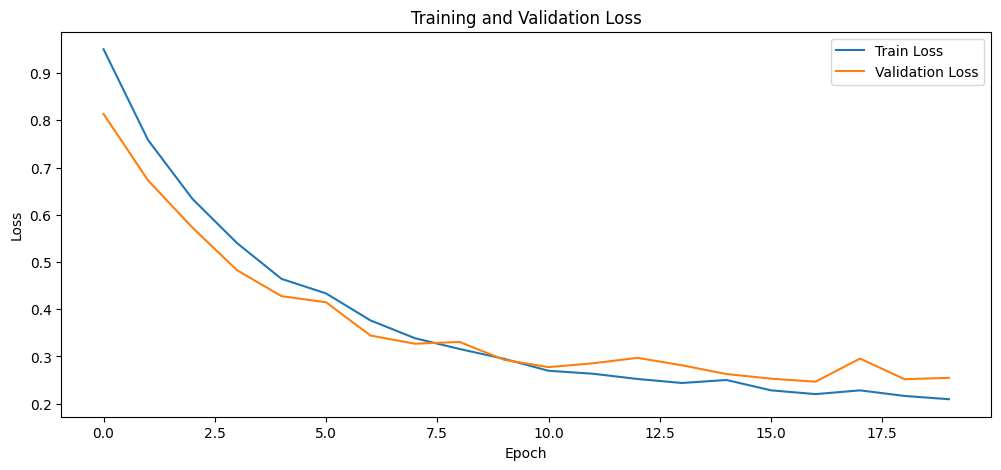

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


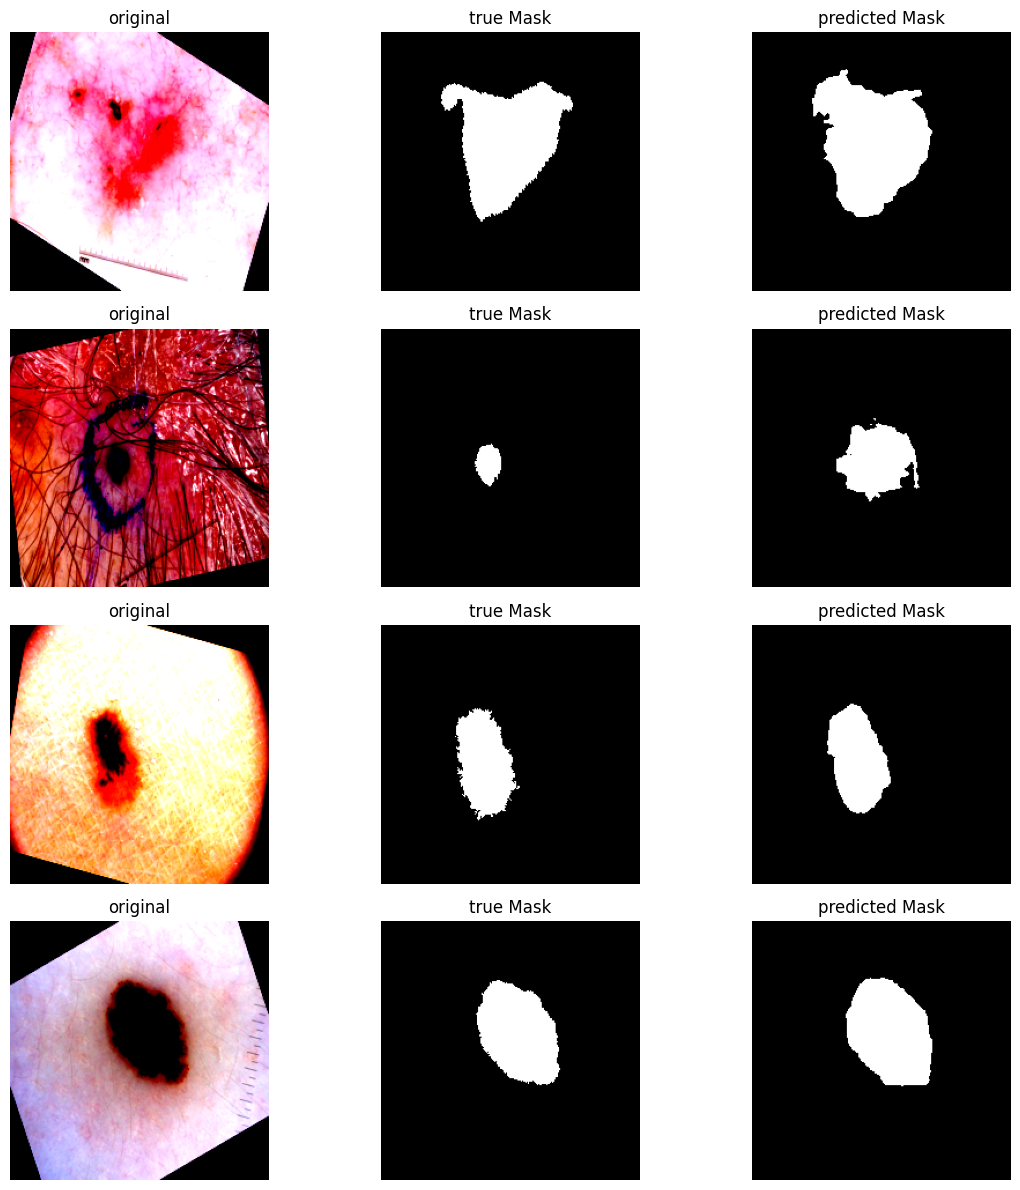

In [24]:
model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
with torch.no_grad():
    preds = model(imgs)
preds = (preds > 0.5).float().cpu()

import numpy as np

def show_samples(imgs, masks, preds, num=4):
    plt.figure(figsize=(12, num*3))
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(np.transpose(imgs[i].cpu().numpy(), (1,2,0)))
        plt.title('original')
        plt.axis('off')
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i][0].cpu(), cmap='gray')
        plt.title('true Mask')
        plt.axis('off')
        plt.subplot(num, 3, i*3+3)
        plt.imshow(preds[i][0], cmap='gray')
        plt.title('predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(imgs, masks, preds, num=4)